In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("bmh")
%matplotlib inline

In [2]:
n = pypsa.Network("capacity/elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-MDES+c5-mdes+c11-mdes+e0.7.nc")

INFO:pypsa.io:Imported network elec_s_37_ec_lv1.25_Co2L0-2H-EQ0.8c-MDES+c5-mdes+c11-mdes+e0.7.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


LCOS =  (capital cost[€/a] + charging cost)/total discharge energy [MWh]

CAPEX-calculation:

In [3]:
len(n.links[n.links.carrier =="DC"])

42

In [4]:
sto_l = n.links.iloc[42:]
sto_l.carrier.unique()

array(['H2 electrolysis', 'H2 fuel cell', 'battery charger',
       'battery discharger', 'mdes-charger', 'mdes-discharger'],
      dtype=object)

CAPEX calculation for MDES

In [5]:
# installed power capacity for MDES
mdes_charger_comp = sto_l.loc[sto_l['carrier']=='mdes-charger']
mdes_discharger_comp = sto_l.loc[sto_l['carrier']=='mdes-discharger']
installed_cap_mdes_charger = mdes_charger_comp.groupby(["bus0", "carrier"]).p_nom_opt.sum()
installed_cap_mdes_discharger = mdes_discharger_comp.groupby(["bus0", "carrier"]).p_nom_opt.sum()

# installed energy capacity for MDES
MDES = n.stores.loc[n.stores['carrier'] == 'MDES']
installed_cap_MDES = MDES.groupby(["bus", "carrier"]).e_nom_opt.sum()

In [6]:
CAPEX_mdes_charger = mdes_charger_comp.groupby(["bus0", "carrier"]).capital_cost.sum()
CAPEX_mdes_discharger = mdes_discharger_comp.groupby(["bus0", "carrier"]).capital_cost.sum()
CAPEX_MDES = MDES.groupby(["bus", "carrier"]).capital_cost.sum()

In [7]:
installed_cap_mdes_charger = installed_cap_mdes_charger.reset_index(drop=True)
installed_cap_mdes_discharger = installed_cap_mdes_discharger.reset_index(drop=True)
installed_cap_MDES = installed_cap_MDES.reset_index(drop=True)

In [8]:
CAPEX_mdes_charger = CAPEX_mdes_charger.reset_index(drop=True)
CAPEX_mdes_discharger = CAPEX_mdes_discharger.reset_index(drop=True)
CAPEX_MDES = CAPEX_MDES.reset_index(drop=True)

In [9]:
CAPEX_MDES_all = (CAPEX_mdes_charger*installed_cap_mdes_charger+
         CAPEX_mdes_discharger*installed_cap_mdes_discharger+
         CAPEX_MDES*installed_cap_MDES)
CAPEX_MDES_all.head()

0    7.967148e+03
1    7.804181e+03
2    4.624497e+03
3    1.909523e+08
4    5.230947e+03
dtype: float64

In [10]:
CAPEX_MDES_all.sum()/1e9

13.02873562172587

total discharging energy [MWh/a]

In [11]:
mdes_discharger_comp.efficiency.unique()

array([0.83666003])

In [12]:
total_dispatch = n.links_t.p0.filter(like='MDES Discharger', axis='columns').sum()
total_dispatch_amount_MDES = total_dispatch*0.83666003
total_dispatch_amount_MDES.head()

Link
AL1 0 MDES Discharger        44.761608
AT1 0 MDES Discharger        27.444089
BA1 0 MDES Discharger        21.869803
BE1 0 MDES Discharger    672291.892461
BG1 0 MDES Discharger        29.543277
dtype: float64

In [13]:
total_dispatch_amount_MDES = total_dispatch_amount_MDES.reset_index(drop=True)

In [14]:
total_dispatch_amount_MDES.sum()/1e6

54.11924042490217

charging cost calculation for MDES [€]

In [15]:
charging_energy = n.links_t.p0.filter(like='MDES Charger', axis='columns')
column_index = charging_energy.T.index

In [16]:
column_index

Index(['AL1 0 MDES Charger', 'AT1 0 MDES Charger', 'BA1 0 MDES Charger',
       'BE1 0 MDES Charger', 'BG1 0 MDES Charger', 'CH1 0 MDES Charger',
       'CZ1 0 MDES Charger', 'DE1 0 MDES Charger', 'DK1 0 MDES Charger',
       'DK2 0 MDES Charger', 'EE6 0 MDES Charger', 'ES1 0 MDES Charger',
       'ES4 0 MDES Charger', 'FI2 0 MDES Charger', 'FR1 0 MDES Charger',
       'GB0 0 MDES Charger', 'GB5 0 MDES Charger', 'GR1 0 MDES Charger',
       'HR1 0 MDES Charger', 'HU1 0 MDES Charger', 'IE5 0 MDES Charger',
       'IT1 0 MDES Charger', 'IT3 0 MDES Charger', 'LT6 0 MDES Charger',
       'LU1 0 MDES Charger', 'LV6 0 MDES Charger', 'ME1 0 MDES Charger',
       'MK1 0 MDES Charger', 'NL1 0 MDES Charger', 'NO2 0 MDES Charger',
       'PL1 0 MDES Charger', 'PT1 0 MDES Charger', 'RO1 0 MDES Charger',
       'RS1 0 MDES Charger', 'SE2 0 MDES Charger', 'SI1 0 MDES Charger',
       'SK1 0 MDES Charger'],
      dtype='object', name='Link')

In [17]:
for item in range(0,len(column_index)):
    filtered = charging_energy[column_index[item]]<1
    charging_energy.loc[filtered, column_index[item]] = 0.0
charging_energy.head()

C:\Users\Joanna\AppData\Local\Temp\ipykernel_27660\539645082.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Link,AL1 0 MDES Charger,AT1 0 MDES Charger,BA1 0 MDES Charger,BE1 0 MDES Charger,BG1 0 MDES Charger,CH1 0 MDES Charger,CZ1 0 MDES Charger,DE1 0 MDES Charger,DK1 0 MDES Charger,DK2 0 MDES Charger,...,MK1 0 MDES Charger,NL1 0 MDES Charger,NO2 0 MDES Charger,PL1 0 MDES Charger,PT1 0 MDES Charger,RO1 0 MDES Charger,RS1 0 MDES Charger,SE2 0 MDES Charger,SI1 0 MDES Charger,SK1 0 MDES Charger
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.0,0.0,0.0,863.191204,0.0,49.466466,0.0,5008.159224,4625.004223,3485.550413,...,0.0,11957.674901,0.0,5422.475690,35.323519,0.0,0.0,0.0,0.0,0.0
2013-01-01 02:00:00,0.0,0.0,0.0,863.191204,0.0,49.466445,0.0,5008.159224,4625.004222,3485.550413,...,0.0,11957.674901,0.0,5422.475690,35.323519,0.0,0.0,0.0,0.0,0.0
2013-01-01 04:00:00,0.0,0.0,0.0,863.191204,0.0,49.493526,0.0,5008.158921,4625.002870,3485.549697,...,0.0,11957.674565,0.0,5422.475690,35.323520,0.0,0.0,0.0,0.0,0.0
2013-01-01 06:00:00,0.0,0.0,0.0,863.184041,0.0,49.493339,0.0,5008.157507,0.000000,3485.527207,...,0.0,3991.969274,0.0,5422.475689,35.323521,0.0,0.0,0.0,0.0,0.0
2013-01-01 08:00:00,0.0,0.0,0.0,863.187278,0.0,49.494254,0.0,5008.158349,4624.989184,3485.547315,...,0.0,11957.669015,0.0,5422.475690,35.324913,0.0,0.0,0.0,0.0,0.0


In [18]:
charging_energy= charging_energy.reset_index(drop=True)
charging_energy = charging_energy.T.reset_index(drop=True)
charging_energy = charging_energy.T

In [19]:
elec_price = n.buses_t.marginal_price.filter(like='MDES', axis='columns')
elec_price.head()

Bus,AL1 0 MDES,AT1 0 MDES,BA1 0 MDES,BE1 0 MDES,BG1 0 MDES,CH1 0 MDES,CZ1 0 MDES,DE1 0 MDES,DK1 0 MDES,DK2 0 MDES,...,MK1 0 MDES,NL1 0 MDES,NO2 0 MDES,PL1 0 MDES,PT1 0 MDES,RO1 0 MDES,RS1 0 MDES,SE2 0 MDES,SI1 0 MDES,SK1 0 MDES
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,39.529393,29.258361,38.271197,14.429002,42.557969,19.296846,38.758651,18.376415,10.314053,12.979331,...,40.172835,12.461469,16.114909,17.823811,16.499691,42.456333,41.364656,16.192640,37.076166,43.347097
2013-01-01 02:00:00,39.540775,29.262985,38.279336,14.429002,42.578485,19.296848,38.761090,18.376415,10.314053,12.979331,...,40.184575,12.461469,16.128585,17.823811,16.499696,42.479493,41.381588,16.208392,37.080050,43.351483
2013-01-01 04:00:00,39.552143,29.267770,38.287756,14.429003,42.598979,19.296850,38.763601,18.376415,10.314053,12.979332,...,40.196259,12.461470,16.142326,17.823811,16.499702,42.502621,41.398411,16.224229,37.084152,43.355983
2013-01-01 06:00:00,39.563500,29.272739,38.296471,14.429004,42.619455,19.296852,38.766185,18.376415,10.314053,12.979332,...,40.207884,12.461470,16.156127,17.823811,16.499708,42.525715,41.415126,16.240157,37.088481,43.360607
2013-01-01 08:00:00,39.575806,29.277914,38.305607,14.429004,42.641650,19.296855,38.768845,18.376415,10.314053,12.979332,...,40.220672,12.461470,16.169982,17.823811,16.499714,42.550804,41.433208,16.256180,37.093063,43.365368


In [20]:
elec_price = elec_price.reset_index(drop=True)
elec_price = elec_price.T.reset_index(drop=True)
elec_price = elec_price.T

In [21]:
charging_cost = charging_energy * elec_price
charging_cost = charging_cost.sum()
charging_cost_MDES = charging_cost
charging_cost_MDES.head() # [€/MWh]

0    0.000000e+00
1    0.000000e+00
2    0.000000e+00
3    5.090268e+07
4    0.000000e+00
dtype: float64

In [22]:
LCOS_MDES = (CAPEX_MDES_all+charging_cost_MDES)/total_dispatch_amount_MDES
LCOS_MDES

0     177.990664
1     284.366563
2     211.455809
3     359.746916
4     177.060483
5     315.644090
6     436.371854
7     330.792594
8     273.202126
9     326.133685
10    481.327062
11    233.879829
12    203.906638
13    759.194024
14    366.354873
15    293.034281
16    263.170431
17    206.059188
18    205.137562
19    215.169803
20    259.594938
21    165.828247
22    177.464640
23    433.127951
24    343.609981
25    442.897090
26    182.660934
27    178.693887
28    292.387583
29    887.918624
30    406.680669
31    245.968294
32    184.836363
33    191.927461
34    815.167287
35    197.464474
36    739.159689
dtype: float64

In [23]:
LCOS_MDES = (LCOS_MDES.div(1e3))*100 #ct/KWh

# LCOS calculation for hydrogen:

In [24]:
n.stores['carrier'].unique()

array(['H2', 'battery', 'MDES'], dtype=object)

In [25]:
# capacity for hydrogen
electrolysis_comp = sto_l.loc[sto_l['carrier']=='H2 electrolysis']
fuel_cell_comp = sto_l.loc[sto_l['carrier']=='H2 fuel cell']
installed_cap_eletrolysis = electrolysis_comp.groupby(["bus0", "carrier"]).p_nom_opt.sum()
installed_cap_fuel_cell = fuel_cell_comp.groupby(["bus0", "carrier"]).p_nom_opt.sum()

# installed energy capacity for hydrogen
H2 = n.stores.loc[n.stores['carrier'] == 'H2']
installed_cap_H2 = H2.groupby(["bus", "carrier"]).e_nom_opt.sum()

In [26]:
installed_cap_eletrolysis = installed_cap_eletrolysis.reset_index(drop=True)
installed_cap_fuel_cell = installed_cap_fuel_cell.reset_index(drop=True)
installed_cap_H2 = installed_cap_H2.reset_index(drop=True)

In [27]:
CAPEX_eletrolysis = electrolysis_comp.groupby(["bus0", "carrier"]).capital_cost.sum()
CAPEX_fuel_cell = fuel_cell_comp.groupby(["bus0", "carrier"]).capital_cost.sum()
CAPEX_H2 = H2.groupby(["bus", "carrier"]).capital_cost.sum()

In [28]:
CAPEX_eletrolysis = CAPEX_eletrolysis.reset_index(drop=True)
CAPEX_fuel_cell = CAPEX_fuel_cell.reset_index(drop=True)
CAPEX_H2 = CAPEX_H2.reset_index(drop=True)

In [29]:
CAPEX_H2_all = (CAPEX_eletrolysis*installed_cap_eletrolysis+
         CAPEX_fuel_cell*installed_cap_fuel_cell+
         CAPEX_H2*installed_cap_H2)
CAPEX_H2_all.head()

0    1.643521e+04
1    2.190269e+04
2    1.176194e+04
3    9.475763e+08
4    6.917627e+03
dtype: float64

In [30]:
CAPEX_H2_all.sum()/1e9

10.818282869269593

total discharge amount [MWh/a]

In [31]:
fuel_cell_comp.efficiency.unique()

array([0.5])

In [32]:
total_dispatch = n.links_t.p0.filter(like='Fuel Cell', axis='columns').sum()
total_dispatch_amount_H2 = total_dispatch*0.5
total_dispatch_amount_H2.head()

Link
AL1 0 H2 Fuel Cell    2.827793e+01
AT1 0 H2 Fuel Cell    2.773133e+01
BA1 0 H2 Fuel Cell    1.783256e+01
BE1 0 H2 Fuel Cell    1.662442e+06
BG1 0 H2 Fuel Cell    1.291753e+01
dtype: float64

In [33]:
total_dispatch_amount_H2 = total_dispatch_amount_H2.reset_index(drop=True)

total_dispatch_amount_H2.sum()/1e6

17.179843800036476

charging cost calculation:

In [34]:
charging_energy = n.links_t.p0.filter(like='Electrolysis', axis='columns')

column_index = charging_energy.T.index

for item in range(0,len(column_index)):
    filtered = charging_energy[column_index[item]]<1
    charging_energy.loc[filtered, column_index[item]] = 0
charging_energy.head()

C:\Users\Joanna\AppData\Local\Temp\ipykernel_27660\2694058702.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Link,AL1 0 H2 Electrolysis,AT1 0 H2 Electrolysis,BA1 0 H2 Electrolysis,BE1 0 H2 Electrolysis,BG1 0 H2 Electrolysis,CH1 0 H2 Electrolysis,CZ1 0 H2 Electrolysis,DE1 0 H2 Electrolysis,DK1 0 H2 Electrolysis,DK2 0 H2 Electrolysis,...,MK1 0 H2 Electrolysis,NL1 0 H2 Electrolysis,NO2 0 H2 Electrolysis,PL1 0 H2 Electrolysis,PT1 0 H2 Electrolysis,RO1 0 H2 Electrolysis,RS1 0 H2 Electrolysis,SE2 0 H2 Electrolysis,SI1 0 H2 Electrolysis,SK1 0 H2 Electrolysis
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.0,0.0,0.0,4326.226165,0.0,3357.216926,488.328575,13932.141657,0.0,0.0,...,0.0,4557.686771,0.0,2396.583119,0.0,0.0,0.0,0.0,0.0,0.000000
2013-01-01 02:00:00,0.0,0.0,0.0,4326.226165,0.0,3357.216923,488.328575,13932.141657,0.0,0.0,...,0.0,4557.686771,0.0,2396.583119,0.0,0.0,0.0,0.0,0.0,0.000000
2013-01-01 04:00:00,0.0,0.0,0.0,4326.226165,0.0,3357.221296,488.328575,13932.141400,0.0,0.0,...,0.0,4557.686452,0.0,2396.583120,0.0,0.0,0.0,0.0,0.0,0.000000
2013-01-01 06:00:00,0.0,0.0,0.0,4326.218989,0.0,3357.221185,488.328393,13932.140353,0.0,0.0,...,0.0,4557.633392,0.0,2396.583119,0.0,0.0,0.0,0.0,0.0,0.000000
2013-01-01 08:00:00,0.0,0.0,0.0,4326.222235,0.0,3357.221771,488.328328,13932.140950,0.0,0.0,...,0.0,4557.681690,0.0,2396.583120,0.0,0.0,0.0,0.0,0.0,503.882823


In [35]:
charging_energy= charging_energy.reset_index(drop=True)
charging_energy = charging_energy.T.reset_index(drop=True)
charging_energy = charging_energy.T

In [36]:
elec_price = n.buses_t.marginal_price.filter(like='H2', axis='columns')
elec_price.head()

Bus,AL1 0 H2,AT1 0 H2,BA1 0 H2,BE1 0 H2,BG1 0 H2,CH1 0 H2,CZ1 0 H2,DE1 0 H2,DK1 0 H2,DK2 0 H2,...,MK1 0 H2,NL1 0 H2,NO2 0 H2,PL1 0 H2,PT1 0 H2,RO1 0 H2,RS1 0 H2,SE2 0 H2,SI1 0 H2,SK1 0 H2
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,28.955732,24.205321,32.271567,16.094595,37.546710,23.75497,24.806949,22.032811,9.594399,12.040363,...,30.072791,14.212084,19.475767,22.165551,15.743669,37.697891,30.898141,19.316362,27.779724,25.839662
2013-01-01 02:00:00,28.982470,24.214331,32.307273,16.094595,37.597249,23.75497,24.806949,22.032811,9.610598,12.058697,...,30.098775,14.212084,19.501007,22.165551,15.748446,37.752502,30.931491,19.334348,27.797136,25.839662
2013-01-01 04:00:00,29.009144,24.223357,32.343025,16.094595,37.647731,23.75497,24.806950,22.032811,9.628848,12.079537,...,30.124694,14.212084,19.526555,22.165551,15.753323,37.807050,30.964752,19.352594,27.814684,25.839663
2013-01-01 06:00:00,29.035754,24.232663,32.378828,16.094595,37.698163,23.75497,24.806950,22.032811,9.649528,12.103466,...,30.150549,14.212084,19.552410,22.165551,15.758307,37.861535,30.997930,19.371103,27.832409,25.839664
2013-01-01 08:00:00,29.065413,24.242281,32.417814,16.094595,37.753480,23.75497,24.806950,22.032811,9.670363,12.127789,...,30.179430,14.212084,19.578575,22.165551,15.763404,37.921380,31.034847,19.389871,27.851063,25.839665


In [37]:
elec_price = elec_price.reset_index(drop=True)
elec_price = elec_price.T.reset_index(drop=True)
elec_price = elec_price.T

In [38]:
charging_cost = charging_energy * elec_price
charging_cost = charging_cost.sum()
charging_cost_H2 = charging_cost
charging_cost_H2.head() # [€/MWh]

0    0.000000e+00
1    0.000000e+00
2    0.000000e+00
3    1.135442e+08
4    0.000000e+00
dtype: float64

In [39]:
LCOS_H2 = (CAPEX_H2_all+charging_cost_H2)/total_dispatch_amount_H2

LCOS_H2 # [€/MWh]

0      581.202578
1      789.817504
2      659.576625
3      638.290245
4      535.522186
5      727.251253
6      940.953251
7      689.260352
8      454.810447
9      490.431367
10     567.317124
11     204.507269
12     180.097504
13     556.666653
14     680.465150
15     346.262017
16     224.762874
17     296.168076
18     640.935688
19     640.788175
20     401.380917
21     685.956539
22     190.081789
23     752.102707
24     829.489900
25     758.098917
26     658.072860
27     589.289786
28     569.327503
29     513.344242
30     829.254575
31     203.848616
32     572.064990
33     621.515856
34     551.228925
35     620.540980
36    1003.622066
dtype: float64

In [40]:
LCOS_H2 = (LCOS_H2.div(1e3))*100 #ct/kWh

# LCOX for battery calculation

In [41]:
# capacity for battery
b_charger_comp = sto_l.loc[sto_l['carrier']=='battery charger'].iloc[:,:]
b_discharger_comp = sto_l.loc[sto_l['carrier']=='battery discharger'].iloc[:,:]
installed_cap_b_charger = b_charger_comp.groupby(["bus0", "carrier"]).p_nom_opt.sum()
installed_cap_b_dischargr = b_discharger_comp.groupby(["bus0", "carrier"]).p_nom_opt.sum()

In [42]:
battery = n.stores.loc[n.stores['carrier']=='battery'].iloc[:,:]
installed_cap_battery = battery.groupby(["bus", "carrier"]).e_nom_opt.sum()

In [43]:
CAPEX_b_charger = b_charger_comp.groupby(["bus0", "carrier"]).capital_cost.sum()
CAPEX_b_discharger = b_discharger_comp.groupby(["bus0", "carrier"]).capital_cost.sum()

In [44]:
CAPEX_battery = battery.groupby(["bus", "carrier"]).capital_cost.sum()

In [45]:
installed_cap_b_charger = installed_cap_b_charger.reset_index(drop=True)
installed_cap_b_dischargr = installed_cap_b_dischargr.reset_index(drop=True)
installed_cap_battery = installed_cap_battery.reset_index(drop=True)

In [46]:
CAPEX_b_charger = CAPEX_b_charger.reset_index(drop=True)
CAPEX_b_discharger = CAPEX_b_discharger.reset_index(drop=True)
CAPEX_battery = CAPEX_battery.reset_index(drop=True)

In [47]:
CAPEX_battery_all = (CAPEX_b_charger*installed_cap_b_charger+
         CAPEX_b_discharger*installed_cap_b_dischargr+
         CAPEX_battery*installed_cap_battery)
CAPEX_battery_all.head()

0    2.958146e+07
1    1.636199e+07
2    2.820861e+06
3    2.400063e+07
4    6.029647e+07
dtype: float64

total discharge amount [MWh/a]

In [48]:
b_discharger_comp.efficiency.unique()

array([0.9797959])

In [49]:
total_dispatch = n.links_t.p0.filter(like='battery discharger', axis='columns').sum()
total_dispatch_amount_battery = total_dispatch*0.9797959
total_dispatch_amount_battery.head()

Link
AL1 0 battery discharger    6.154258e+05
AT1 0 battery discharger    3.254011e+05
BA1 0 battery discharger    6.063615e+04
BE1 0 battery discharger    4.867505e+05
BG1 0 battery discharger    1.328007e+06
dtype: float64

In [50]:
total_dispatch_amount_battery = total_dispatch_amount_battery.reset_index(drop=True)

In [51]:
total_dispatch_amount_battery.sum()/1e6

155.6182052409394

charging cost calculation:

In [52]:
b_charger_comp.efficiency.unique()

array([0.9797959])

In [53]:
charging_energy = n.links_t.p0.filter(like='battery charger', axis='columns')

In [54]:
column_index = charging_energy.T.index

In [55]:
for item in range(0,len(column_index)):
    filtered = charging_energy[column_index[item]]<1
    charging_energy.loc[filtered, column_index[item]] = 0
charging_energy.head()

C:\Users\Joanna\AppData\Local\Temp\ipykernel_27660\1987913432.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Link,AL1 0 battery charger,AT1 0 battery charger,BA1 0 battery charger,BE1 0 battery charger,BG1 0 battery charger,CH1 0 battery charger,CZ1 0 battery charger,DE1 0 battery charger,DK1 0 battery charger,DK2 0 battery charger,...,MK1 0 battery charger,NL1 0 battery charger,NO2 0 battery charger,PL1 0 battery charger,PT1 0 battery charger,RO1 0 battery charger,RS1 0 battery charger,SE2 0 battery charger,SI1 0 battery charger,SK1 0 battery charger
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.00000,0.00000,378.390778,0.000000,0.000000,200.512620,4.434739,311.066431,1367.493988,...,0.000000,0.0,0.0,2.460839,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2013-01-01 02:00:00,0.000000,0.00000,0.00000,307.886338,0.000000,0.000000,151.853597,3.843136,311.066376,1367.493917,...,0.000000,0.0,0.0,2.455441,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2013-01-01 04:00:00,0.000000,0.00000,0.00000,482.396080,0.000000,1856.912186,246.942413,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.453400,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2013-01-01 06:00:00,0.000000,0.00000,0.00000,0.000000,389.265188,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.452227,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2013-01-01 08:00:00,663.055529,31.88079,86.03711,177.327093,1495.773272,9572.050803,0.000000,4.520731,60.386200,100.484525,...,1927.927135,0.0,0.0,2.456640,209.097488,1.323956,3172.371489,0.0,115.590678,52.284684


In [56]:
charging_energy= charging_energy.reset_index(drop=True)
charging_energy = charging_energy.T.reset_index(drop=True)
charging_energy = charging_energy.T

#df = df.reset_index(drop=True).T.reset_index(drop=True).T

In [57]:
elec_price = n.buses_t.marginal_price.filter(like='battery', axis='columns')
elec_price.head()

Bus,AL1 0 battery,AT1 0 battery,BA1 0 battery,BE1 0 battery,BG1 0 battery,CH1 0 battery,CZ1 0 battery,DE1 0 battery,DK1 0 battery,DK2 0 battery,...,MK1 0 battery,NL1 0 battery,NO2 0 battery,PL1 0 battery,PT1 0 battery,RO1 0 battery,RS1 0 battery,SE2 0 battery,SI1 0 battery,SK1 0 battery
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,40.578345,20.026151,30.004538,0.047738,42.509504,15.368332,10.315559,0.050134,1.169974,0.771487,...,43.597794,0.041057,14.859922,-4.793014,11.644483,41.656795,45.017362,14.885967,22.761925,19.779371
2013-01-01 02:00:00,40.578326,20.025756,30.004065,0.047731,42.509497,15.368323,10.315534,0.049839,1.169971,0.771486,...,43.597787,0.070545,14.863828,-4.805413,11.644483,41.649982,45.017353,14.890035,22.448170,19.779382
2013-01-01 04:00:00,40.578290,15.890271,30.003290,0.047745,42.509480,10.544694,10.315547,4.126702,4.110611,4.104370,...,43.597762,2.250777,14.867812,-4.811601,11.644482,41.634763,45.017314,14.894082,21.886757,19.779392
2013-01-01 06:00:00,20.445126,13.324889,19.534847,9.889626,20.905713,10.544690,10.871582,8.568877,8.033715,8.022612,...,20.693003,9.327143,14.871851,-4.814542,11.644481,21.063793,20.595848,14.898083,17.026747,19.779384
2013-01-01 08:00:00,20.426956,9.174349,10.273503,9.700693,20.905692,7.630311,11.041899,8.035307,8.033720,8.022614,...,20.684552,8.809828,14.875853,-4.814877,11.644479,21.045902,20.573078,14.901991,9.593418,12.804984


In [58]:
elec_price = elec_price.reset_index(drop=True)
elec_price = elec_price.T.reset_index(drop=True)
elec_price = elec_price.T

In [59]:
charging_cost = charging_energy * elec_price
charging_cost = charging_cost.sum()
charging_cost_battery = charging_cost
charging_cost_battery.head() # [€/MWh]

0    2.089425e+07
1    1.560111e+07
2    2.579210e+06
3    1.638571e+07
4    5.346608e+07
dtype: float64

In [60]:
LCOS_battery = (CAPEX_battery_all+charging_cost_battery)/total_dispatch_amount_battery
LCOS_battery # [€/MWh]

0      82.017533
1      98.226784
2      89.056965
3      82.971332
4      85.664106
5      93.539246
6      93.102990
7      85.872535
8      87.923322
9      88.259677
10    113.550433
11     72.654529
12     75.217972
13    279.080373
14     97.285467
15     50.690120
16     21.270981
17     75.825531
18     31.038153
19     25.571053
20    109.612396
21     79.835836
22     73.417742
23     86.390498
24     82.956633
25     87.470598
26     83.094252
27     81.839000
28     30.899384
29    285.893719
30     47.198460
31     75.735425
32     69.090474
33     77.579970
34    221.240869
35     86.233368
36     97.623396
dtype: float64

In [61]:
LCOS_battery = (LCOS_battery.div(1e3))*100 #ct/kWh
LCOS_battery

0      8.201753
1      9.822678
2      8.905696
3      8.297133
4      8.566411
5      9.353925
6      9.310299
7      8.587254
8      8.792332
9      8.825968
10    11.355043
11     7.265453
12     7.521797
13    27.908037
14     9.728547
15     5.069012
16     2.127098
17     7.582553
18     3.103815
19     2.557105
20    10.961240
21     7.983584
22     7.341774
23     8.639050
24     8.295663
25     8.747060
26     8.309425
27     8.183900
28     3.089938
29    28.589372
30     4.719846
31     7.573542
32     6.909047
33     7.757997
34    22.124087
35     8.623337
36     9.762340
dtype: float64

# LCOS Plots 

In [62]:
battery_discharger_p = b_discharger_comp.groupby("bus0").p_nom_opt.sum().rename("Market potential for\ndischarger [MW]").to_frame()
mdes_discharger_p = mdes_discharger_comp.groupby("bus0").p_nom_opt.sum().rename("Market potential for\ndischarger [MW]").to_frame()
fuel_cell_p = fuel_cell_comp.groupby("bus0").p_nom_opt.sum().rename("Market potential for\ndischarger [MW]").to_frame()

In [63]:
LCOS_battery.index = battery_discharger_p.index
LCOS_MDES.index = mdes_discharger_p.index
LCOS_H2.index = fuel_cell_p.index

In [64]:
battery_data = battery_discharger_p
MDES_data = mdes_discharger_p
H2_data = fuel_cell_p

In [65]:
battery_data['LCOS [ct/kWh]'] = LCOS_battery
MDES_data['LCOS [ct/kWh]'] = LCOS_MDES
H2_data['LCOS [ct/kWh]'] = LCOS_H2

In [66]:
battery_data['storage'] = "Battery"
MDES_data['storage'] = "MDES"
H2_data['storage'] = "Hydrogen"

In [67]:
battery_data = battery_data[battery_data.iloc[:,0]>1]
MDES_data = MDES_data[MDES_data.iloc[:,0]>1]
H2_data = H2_data[H2_data.iloc[:,0]>1]

In [68]:
n.links.carrier.unique()

array(['DC', 'H2 electrolysis', 'H2 fuel cell', 'battery charger',
       'battery discharger', 'mdes-charger', 'mdes-discharger'],
      dtype=object)

In [69]:
MDES_data

,Market potential for\ndischarger [MW],LCOS [ct/kWh],storage
bus0,,,
BE1 0 MDES,1533.399968,35.974692,MDES
CH1 0 MDES,86.353471,31.564409,MDES
DE1 0 MDES,8105.061665,33.079259,MDES
DK1 0 MDES,5708.184300,27.320213,MDES
DK2 0 MDES,5609.813778,32.613368,MDES
EE6 0 MDES,791.507905,48.132706,MDES
ES1 0 MDES,3086.318122,23.387983,MDES
ES4 0 MDES,151.029748,20.390664,MDES
FI2 0 MDES,679.644211,75.919402,MDES


In [70]:
H2_data

,Market potential for\ndischarger [MW],LCOS [ct/kWh],storage
bus0,,,
BE1 0 H2,6219.647092,63.829025,Hydrogen
CH1 0 H2,8216.614049,72.725125,Hydrogen
CZ1 0 H2,3279.743542,94.095325,Hydrogen
DE1 0 H2,30297.718229,68.926035,Hydrogen
FR1 0 H2,6149.636842,68.046515,Hydrogen
GB0 0 H2,345.671795,34.626202,Hydrogen
IE5 0 H2,627.376784,40.138092,Hydrogen
IT1 0 H2,5937.671204,68.595654,Hydrogen
LU1 0 H2,1023.461912,82.948990,Hydrogen


In [71]:
battery_data

,Market potential for\ndischarger [MW],LCOS [ct/kWh],storage
bus0,,,
AL1 0 battery,676.729465,8.201753,Battery
AT1 0 battery,779.617643,9.822678,Battery
BA1 0 battery,87.898011,8.905696,Battery
BE1 0 battery,1143.588884,8.297133,Battery
BG1 0 battery,1526.618652,8.566411,Battery
CH1 0 battery,10254.269467,9.353925,Battery
CZ1 0 battery,587.150278,9.310299,Battery
DE1 0 battery,7.524910,8.587254,Battery
DK1 0 battery,317.492660,8.792332,Battery


C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



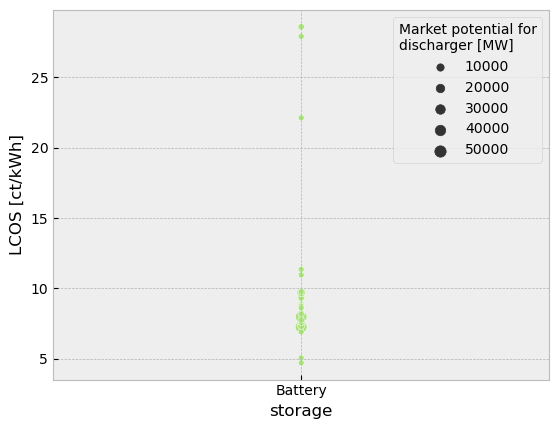

In [72]:
ax = sns.scatterplot(
    x="storage", 
    y="LCOS [ct/kWh]", 
    size="Market potential for\ndischarger [MW]",
    data=battery_data,
    color=n.carriers.loc["battery"].color,)

In [73]:
LCOS = pd.concat([battery_data, MDES_data, H2_data], axis=0)
LCOS

,Market potential for\ndischarger [MW],LCOS [ct/kWh],storage
bus0,,,
AL1 0 battery,676.729465,8.201753,Battery
AT1 0 battery,779.617643,9.822678,Battery
BA1 0 battery,87.898011,8.905696,Battery
BE1 0 battery,1143.588884,8.297133,Battery
BG1 0 battery,1526.618652,8.566411,Battery
...,...,...,...
IT1 0 H2,5937.671204,68.595654,Hydrogen
LU1 0 H2,1023.461912,82.948990,Hydrogen
NL1 0 H2,4248.108978,56.932750,Hydrogen


C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_ca

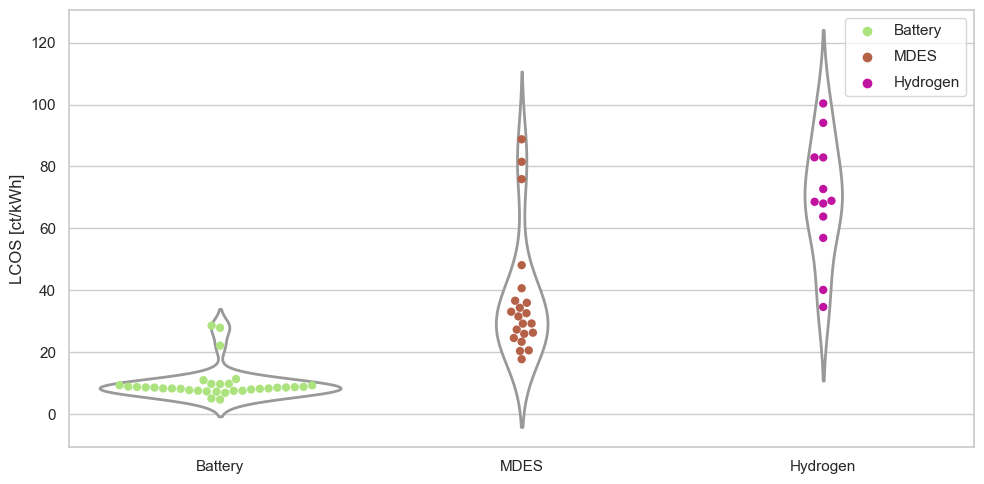

In [74]:
plt.figure(figsize=(10,5))
sns.set(style="whitegrid", palette="muted")
color = [n.carriers.loc["battery"].color,n.carriers.loc["MDES"].color,n.carriers.loc["H2"].color]
ax = sns.swarmplot(x="storage", 
              y="LCOS [ct/kWh]", 
              hue="storage",
              data=LCOS,
              palette=color,
              size=6,
             )
ax = sns.violinplot(x="storage", y="LCOS [ct/kWh]", data=LCOS, color="white", linewidth=2, inner=None)
ax.set_xlabel('')
ax.legend(prop={'size':11},labelspacing=0.8)
plt.tight_layout()
plt.savefig("LCOS_distribution.pdf", dpi=750)
plt.show()

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_ca

<Axes: xlabel='storage', ylabel='LCOS [ct/kWh]'>

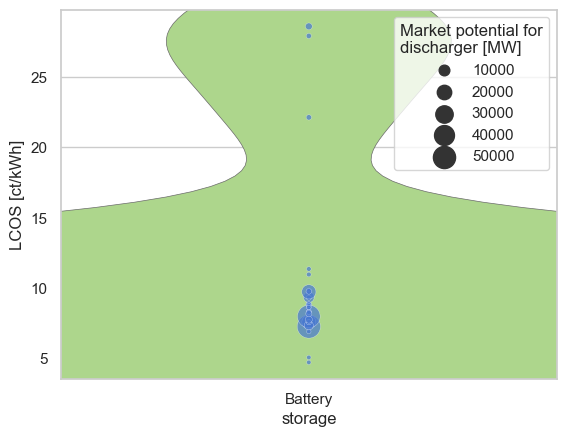

In [75]:
sns.violinplot(data=battery_data, 
               x="storage", 
               y="LCOS [ct/kWh]", 
               bw=.6,
               color=n.carriers.loc["battery"].color,
               linewidth=0.5,
               inner=None)

sns.scatterplot(x="storage", 
                y="LCOS [ct/kWh]",
                palette="Blues_r", 
                size="Market potential for\ndischarger [MW]",
                sizes=(10,280),
                alpha=0.7,
                data=battery_data,
                )

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\AppData\Local\Temp\ipykernel_27660\3017717710.py:3: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use is

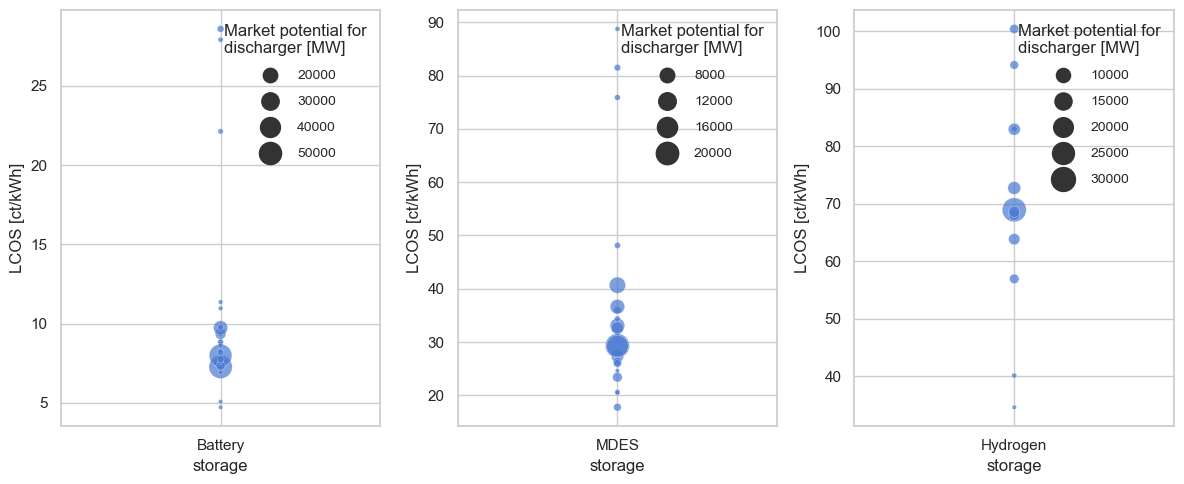

In [76]:
sns.set(style="whitegrid", palette="muted")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
scatter1 = sns.scatterplot(x="storage", 
                y="LCOS [ct/kWh]",
                palette="Blues_r", 
                size="Market potential for\ndischarger [MW]",
                sizes=(10,280),
                alpha=0.7,
                ax=ax1,
                data=battery_data,
                )

scatter2 = sns.scatterplot(x="storage", 
                y="LCOS [ct/kWh]",
                palette="Blues_r", 
                size="Market potential for\ndischarger [MW]",
                alpha=0.7,
                sizes=(10,300),
                ax=ax2,
                data=MDES_data,
                )
scatter3 = sns.scatterplot(x="storage", 
                y="LCOS [ct/kWh]",
                palette="Blues_r", 
                size="Market potential for\ndischarger [MW]",
                alpha=0.7,
                sizes=(10,300),
                ax=ax3,
                data=H2_data,
                )

for ax, scatter in zip([ax1, ax2, ax3], [scatter1, scatter2, scatter3]):
    handles, labels = scatter.get_legend_handles_labels()
    legend = ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right', 
                       title='Market potential for\ndischarger [MW]', frameon=False,labelspacing=0.8)
    for text in legend.get_texts():
        text.set_fontsize('small') 
        
plt.tight_layout()
plt.savefig("Market potential.pdf",dpi=750)
plt.show()

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Joanna\Anaconda\envs\esm-2023\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_ca

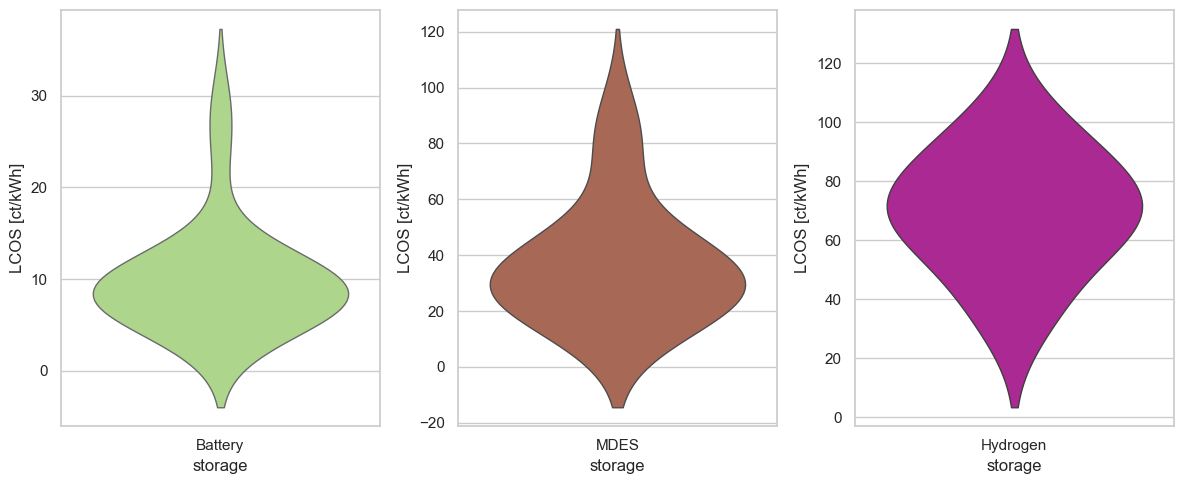

In [77]:
sns.set(style="whitegrid", palette="muted")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

sns.violinplot(data=battery_data, 
               x="storage", 
               y="LCOS [ct/kWh]", 
               bw=.8,
               color=n.carriers.loc["battery"].color,
               linewidth=1,
               ax=ax1,
               inner = None)

sns.violinplot(data=MDES_data, 
               x="storage", 
               y="LCOS [ct/kWh]", 
               bw=.8,
               color=n.carriers.loc["MDES"].color,
               linewidth=1, 
               ax=ax2,
               inner = None)

sns.violinplot(data=H2_data, 
               x="storage", 
               y="LCOS [ct/kWh]", 
               bw=.8,
               color=n.carriers.loc["H2"].color,
               linewidth=1, 
               ax=ax3,
               inner = None)
plt.tight_layout()
#plt.savefig("modelled LCOS.pdf", bbox_inches='tight')
plt.show()